In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from funkwpap import sympy_to_gurobi, Firm, Country, Sector, Regulator, get_emission
import sympy as sp, pandas as pd, numpy as np, tqdm, time, sys, matplotlib.pyplot as plt
x = sp.symbols('x')
y = sp.symbols('y')

In [2]:
cap = 200 # total emission cap
Regulator10 = Regulator("test1", permit_price = 2.4079, emission_cap = cap)
sector1 = Sector('cement', price_demand_function= 100 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator10)
sector2 = Sector('steel', price_demand_function=150 - 0.1*x, free_emission_multiplier= 0, regulator= Regulator10)
sector3 = Sector('paper', price_demand_function= 200 - 0.02*x**1.5, free_emission_multiplier= 0, regulator= Regulator10)
country1 = Country('DE', 1, regulator= Regulator10)
country2 = Country('FI', 0.5, regulator= Regulator10)
country3 = Country('GR', size= 0.1, regulator= Regulator10)

# Create Firms using objects
firm1 = Firm('firm1', 1, 1, x*0, 10*x+ 2*x**2 + 0.1*x**3 , 0, 0, 0, regulator= Regulator10)
firm2 = Firm('firm2', 1, 2, x*0, 11*x+ 3*x**2 + 0.2*x**3, 0, 0, 0, regulator= Regulator10)
firm3 = Firm('firm3', 1, 3, x*0, 5*x+ 4*x**2 + 5*x**3 , 0, 0, 0, regulator= Regulator10)
firm4 = Firm('firm4', 2, 1, x*0, 7*x+ 5*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator10)
firm5 = Firm('firm5', 2, 2, x*0, 1*x+ 6*x**2 + 2*x**3 , 0, 0, 0, regulator= Regulator10)
firm6 = Firm('firm6', 2, 3, x*0, 2*x+ 7*x**2 + 3*x**3 , 0, 0, 0, regulator= Regulator10)
firm7 = Firm('firm7', 3, 1, x*0, 3*x+ 8*x**2 + 4*x**3 , 0, 0, 0, regulator= Regulator10)
firm8 = Firm('firm8', 3, 2, x*0, 4*x+ 9*x**2 + 10*x**3 , 0, 0, 0, regulator= Regulator10)
firm9 = Firm('firm9', 3, 3, x*0, 5*x+ 10*x**2 + 11*x**3 , 0, 0, 0, regulator= Regulator10)




print(sector1.firms)  # List of firms in sector1
print(country1.firms)  # List of firms in country1
print(Regulator10.firm_registry)  # Dictionary of all firms

for firm in Regulator10.firm_registry.values():
    print(firm.name, firm.sector.name, firm.country.name)

[Firm(id=1, name='firm1', sector_id=1, country_id=1, actual_output=0, emission=0, profit=0), Firm(id=2, name='firm2', sector_id=1, country_id=2, actual_output=0, emission=0, profit=0), Firm(id=3, name='firm3', sector_id=1, country_id=3, actual_output=0, emission=0, profit=0)]
[Firm(id=1, name='firm1', sector_id=1, country_id=1, actual_output=0, emission=0, profit=0), Firm(id=4, name='firm4', sector_id=2, country_id=1, actual_output=0, emission=0, profit=0), Firm(id=7, name='firm7', sector_id=3, country_id=1, actual_output=0, emission=0, profit=0)]
{1: Firm(id=1, name='firm1', sector_id=1, country_id=1, actual_output=0, emission=0, profit=0), 2: Firm(id=2, name='firm2', sector_id=1, country_id=2, actual_output=0, emission=0, profit=0), 3: Firm(id=3, name='firm3', sector_id=1, country_id=3, actual_output=0, emission=0, profit=0), 4: Firm(id=4, name='firm4', sector_id=2, country_id=1, actual_output=0, emission=0, profit=0), 5: Firm(id=5, name='firm5', sector_id=2, country_id=2, actual_out

In [3]:
# Read a csv file that has the column names in the first row and some entries are lists of floats which are writeen inside double quotes to seperate those commas from the commans of the scv file. 
with open ('../data/generated/exp4_how_Free_allocation_of_one_sector_affects_others_v0_1.csv', 'r') as f:
    df = pd.read_csv(f)

print(df)

    Free Allocation  Emission Cap  Permit Price  \
0          0.000000   3074.537827     29.087067   
1          0.052632   3074.537827     30.040741   
2          0.105263   3074.537827     30.517578   
3          0.157895   3074.537827     30.994415   
4          0.210526   3074.537827     31.471252   
5          0.263158   3074.537827     31.948090   
6          0.315789   3074.537827     31.948090   
7          0.368421   3074.537827     32.901764   
8          0.421053   3074.537827     33.855438   
9          0.473684   3074.537827     35.285950   
10         0.526316   3074.537827     35.762787   
11         0.578947   3074.537827     36.239624   
12         0.631579   3074.537827     37.193298   
13         0.684211   3074.537827     38.623810   
14         0.736842   3074.537827     39.100647   
15         0.789474   3074.537827     40.054321   
16         0.842105   3074.537827     41.961670   
17         0.894737   3074.537827     41.961670   
18         0.947368   3074.5378

In [4]:

Sales = []
Abatements = []
Trades = []
Outputs = []
Emissions = []
Profits = []
for i in range(len(df)):
    Regulator10.emission_cap = df['Emission Cap'][i]
    Regulator10.permit_price = df['Permit Price'][i]
    out = df['Outputs'][i].replace('(','').replace(')','').split(',')
    em = df['Emissions'][i].replace('(','').replace(')','').split(',')
    pr = df['Profits'][i].replace('(','').replace(')','').split(',')
    sal = []
    abat = []
    trad = []


    for firm in Regulator10.firm_registry.values():
        firm.actual_output = float(out[firm.id-1])
        firm.emission = float(em[firm.id-1])
        firm.profit = float(pr[firm.id-1])
        sal.append(firm.calculate_sales())
        abat.append(firm.calculate_abatement())
        trad.append(firm.calculate_trading())
    Sales.append(sal)
    Abatements.append(abat)
    Trades.append(trad)
    Outputs.append(out)
    Emissions.append(em)
    Profits.append(pr)
print(Trades)

# Combine all the data back into one dataframe
df['Sales'] = Sales
df['Abatements'] = Abatements
df['Trades'] = Trades
df['Outputs'] = Outputs
df['Emissions'] = Emissions
df['Profits'] = Profits
print(df)

# go through the columns "Sales", "Abatements", "Trades", "Outputs", "Emissions", "Profits" and convert the list of strings to list of floats
for col in ["Sales", "Abatements", "Trades", "Outputs", "Emissions", "Profits"]:
    for i in range(len(df)):
        df[col][i] = [float(x) for x in df[col][i]]


[[2436.63226169141, 2515.04892814258, 2509.26846866343, 4161.01782173251, 4030.32720472778, 4155.30227966855, 1473.48538578827, 1483.96422656733, 1482.30265021932, 3033.17867474493, 3003.04188935667, 2773.52258303124, 4493.39714007795, 4722.91644640339, 4807.32746655701, 2469.40405514385, 2498.50296621439, 2508.82756134252, 2508.82756134252, 4457.33111692416, 4428.23220585362, 4198.71289952819, 4428.23220585362, 1469.08261866497, 1479.76485274967, 1466.97389928706, 1439.35070866658, 2773.52258303124, 3003.04188935667, 3032.14080042722], [2333.41770125686, 2597.50954873742, 2591.53956599665, 4294.90865928878, 4162.46908029263, 4291.54169867407, 1510.21676111039, 1512.80197285020, 1518.26653006731, 3132.62715588410, 3098.41383080089, 2844.83692878912, 4621.10081557507, 4874.67771758684, 4945.32393964360, 2547.27967415486, 2580.42109625421, 2762.39760424357, 2762.39760424357, 4317.78560385765, 4570.33169865839, 4316.75479664662, 4570.33169865839, 1512.40020715755, 1524.62280259989, 1516.1

C:\Users\Kostas\AppData\Local\Temp\ipykernel_13820\929124784.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[col][i] = [float(x) for x in df[col][i]]
C:\Users\Kostas\AppData\Local\Temp\ipykernel_13820\929124784.py:45: SettingWithCopy

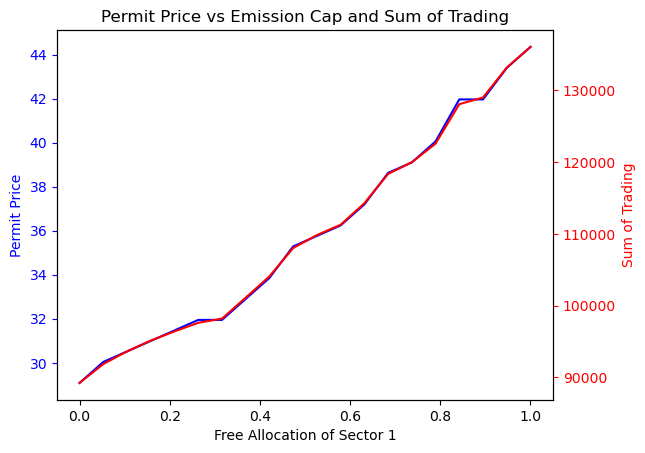

In [5]:


# Plot the permit price against the emission cap
fig, ax1 = plt.subplots()

ax1.plot(df['Free Allocation'][0:], df['Permit Price'][0:], 'b-')
ax1.set_xlabel('Free Allocation of Sector 1')
ax1.set_ylabel('Permit Price', color='b')
ax1.tick_params('y', colors='b')

# Create a secondary y-axis
ax2 = ax1.twinx()
trading_sums = [sum(trading) for trading in df['Trades']]
ax2.plot(df['Free Allocation'][0:], trading_sums, 'r-')
ax2.set_ylabel('Sum of Trading', color='r')
ax2.tick_params('y', colors='r')

plt.title('Permit Price vs Emission Cap and Sum of Trading')
plt.show()

   